# Training a CNN on biotic/non-biotic test set

Just doing biotic/non biotic, using the pre-defined training set.
We can choose if we use the full or small training set.

TODO:
- Load the model back in and do hard negative mining on the training set
- We should be doing hyperopt here
- Compare directly to a forest

In [20]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import csv
import os
import sys
import numpy as np
import collections
import scipy.io

from lasagne import layers
from lasagne.nonlinearities import softmax
from lasagne.updates import adam
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import TrainSplit
# from nolearn.lasagne.objective import categorical_crossentropy
from nolearn.lasagne import objective

from lasagne.layers import get_all_params

sys.path.append(os.path.expanduser('~/projects/engaged_hackathon/'))
from engaged.features import evaluation

from time import time

from sklearn import metrics
from sklearn.metrics import roc_curve, auc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading in the training/test data

This split was done in 'Biotic slice extraction'

In [21]:
datapath = '/home/michael/projects/engaged_hackathon_data/detection/train_test_patches/'
data_small = scipy.io.loadmat(datapath + 'small.mat')
data_big = scipy.io.loadmat(datapath + 'unbalanced_128.mat')

datasetsize = 'full'

train, test = {}, {}
train['X'] = data_big['X_train']
train['y'] = data_big['y_train'].ravel()
test['X'] = data_big['X_test']
test['y'] = data_big['y_test'].ravel()

print "Training data"
for key, val in train.iteritems():
    print key, val.shape
    
print "Testing data"
for key, val in test.iteritems():
    print key, val.shape

Training data
y (100000,)
X (100000, 1, 128, 19)
Testing data
y (30000,)
X (30000, 1, 128, 19)


In [22]:
print train['y'].mean()
print test['y'].mean()

0.12559
0.1018


## Setting up and training the CNN, using NoLearn (& Lasagne)

In [23]:
# Xmnist
# todo - change architcture
layers0 = [
    # layer dealing with the input data
    (layers.InputLayer, {'shape': (None, train['X'].shape[1], train['X'].shape[2], train['X'].shape[3])}),

    # first stage of our convolutional layers
    (layers.Conv2DLayer, {'num_filters': 96, 'filter_size': 5}),
#     (layers.Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
#     (layers.Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
#     (layers.Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
    (layers.Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
    (layers.MaxPool2DLayer, {'pool_size': 2}),
    (layers.DropoutLayer, {}),
    # second stage of our convolutional layers
#     (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': 3}),
    (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': 3}),
    (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': 3}),
    (layers.MaxPool2DLayer, {'pool_size': 2}),
    (layers.DropoutLayer, {}),

    # two dense layers with dropout
    (layers.DenseLayer, {'num_units': 64}),
    (layers.DropoutLayer, {}),
    (layers.DenseLayer, {'num_units': 64}),

    # the output layer
    (layers.DenseLayer, {'num_units': 2 , 'nonlinearity': softmax}),
]

def regularization_objective(layers, lambda1=0., lambda2=0., *args, **kwargs):
    # default loss
    losses = objective(layers, *args, **kwargs)
#     target=, loss_function=categorical_crossentropy, aggregate='mean')

    # get the layers' weights, but only those that should be regularized
    # (i.e. not the biases)
    weights = get_all_params(layers[-1], regularizable=True)
    # sum of absolute weights for L1
    sum_abs_weights = sum([abs(w).sum() for w in weights])
    # sum of squared weights for L2
    sum_squared_weights = sum([(w ** 2).sum() for w in weights])
    # add weights to regular loss
    losses += lambda1 * sum_abs_weights + lambda2 * sum_squared_weights
    return losses


net0 = NeuralNet(
    layers=layers0,
    max_epochs=12,

    update=adam,
    update_learning_rate=0.002,

    objective=regularization_objective,
    objective_lambda2=0.0025,
    regression=False,
    train_split=TrainSplit(eval_size=0.25),
    verbose=1,
)

# Train the network
net0.fit(train['X'], train['y']);

# Neural Network with 823330 learnable parameters

## Layer information

  #  name        size
---  ----------  ---------
  0  input0      1x128x19
  1  conv2d1     96x124x15
  2  conv2d2     96x122x13
  3  maxpool2d3  96x61x7
  4  dropout4    96x61x7
  5  conv2d5     128x59x5
  6  conv2d6     128x57x3
  7  maxpool2d7  128x29x2
  8  dropout8    128x29x2
  9  dense9      64
 10  dropout10   64
 11  dense11     64
 12  dense12     2

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -------
      1       0.47646       0.28758      1.65676      0.91646  254.28s
      2       0.27887       0.26290      1.06076      0.92394  253.56s
      3       0.26590       0.25004      1.06345      0.92666  254.26s
      4       0.26160       0.25019      1.04562      0.92463  253.84s
      5       0.25930       0.24763      1.04715      0.92650  256.44s
      6       0.25855       0.24561      1.05269      0.92766  256.52s


## Classification accuracy on the test set

In [24]:
print test['y'].mean()

0.1018


In [25]:
# on the unbalanced test set
pred_y_unbal = net0.predict_proba(test['X'])[:, 1]
unbalanced_test_accuracy = metrics.accuracy_score(test['y'], pred_y_unbal>0.5)
print "Unbalanced test accuracy is %f" % unbalanced_test_accuracy

# on the balanced test set
data_balanced = scipy.io.loadmat(datapath + '128.mat')
test_bal = {}
test_bal['X'] = data_balanced['X_test']
test_bal['y'] = data_balanced['y_test'].ravel()
pred_y_bal = net0.predict_proba(test_bal['X'])[:, 1]
balanced_test_accuracy = metrics.accuracy_score(test_bal['y'], pred_y_bal>0.5)
print "Balanced test accuracy is %f" % balanced_test_accuracy

Unbalanced test accuracy is 0.939433
Balanced test accuracy is 0.764532


In [26]:
# do class balancing on the unbalanced set
accs = 0
for target in [0, 1]:
    idxs = test['y']==target
    accs += metrics.accuracy_score(test['y'][idxs], pred_y_unbal[idxs]>0.5)
accs /= 2
print accs, pred_y_unbal.shape

0.781780872376 (30000,)


## ROC Curve

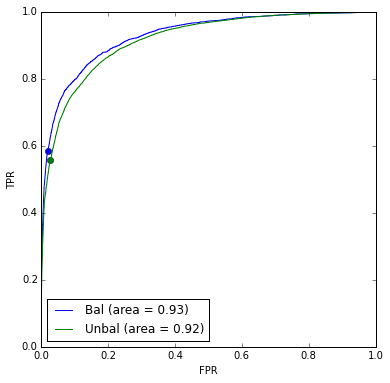

In [27]:
from sklearn.metrics import roc_curve, auc

# plotting this line
plt.figure(figsize=(6, 6))
fpr, tpr, thresh = roc_curve(test['y'], pred_y_unbal.ravel())
mid_idx = np.argmin(np.abs(thresh-0.5))
plt.plot(fpr[mid_idx], tpr[mid_idx], 'bo')
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr , label='Bal (area = %0.2f)' % (roc_auc))

fpr, tpr, thresh = roc_curve(test_bal['y'], pred_y_bal.ravel())
mid_idx = np.argmin(np.abs(thresh-0.5))
plt.plot(fpr[mid_idx], tpr[mid_idx], 'go')
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr , label='Unbal (area = %0.2f)' % (roc_auc))

plt.legend(loc='best')
plt.xlabel('FPR')
plt.ylabel('TPR')

# evaluation.plot_roc_curve(test_bal['y'], pred_y_bal.ravel(), label='Balanced')
# evaluation.plot_roc_curve(test['y'], pred_y_unbal.ravel(), label='Unbalanced')

In [28]:
print datasetsize

full


In [29]:
# Save the model to disk...
import cPickle as pickle

savedir = '/home/michael/projects/engaged_hackathon_data/detection/models/'
with open(savedir + 'cnn_' + datasetsize + '_balanced.pkl', 'w') as f:
    pickle.dump(net0, f, -1)


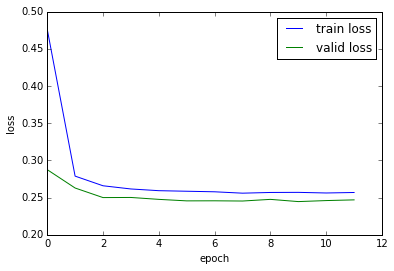

In [30]:
# Introspection into the model

from nolearn.lasagne.visualize import plot_loss
from nolearn.lasagne.visualize import plot_conv_weights
from nolearn.lasagne.visualize import plot_conv_activity
from nolearn.lasagne.visualize import plot_occlusion
plot_loss(net0)

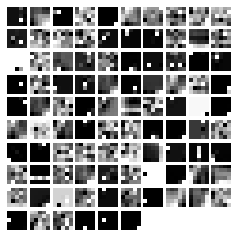

In [31]:
plot_conv_weights(net0.layers_[1], figsize=(4, 4))

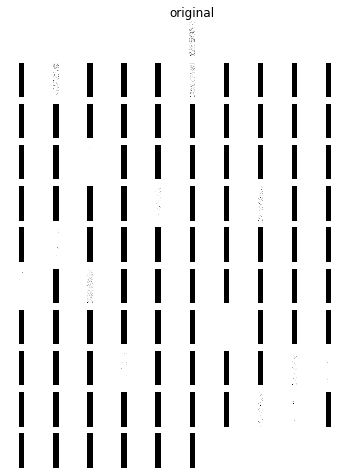

In [32]:
plot_conv_activity(net0.layers_[1], train['X'][0:1])

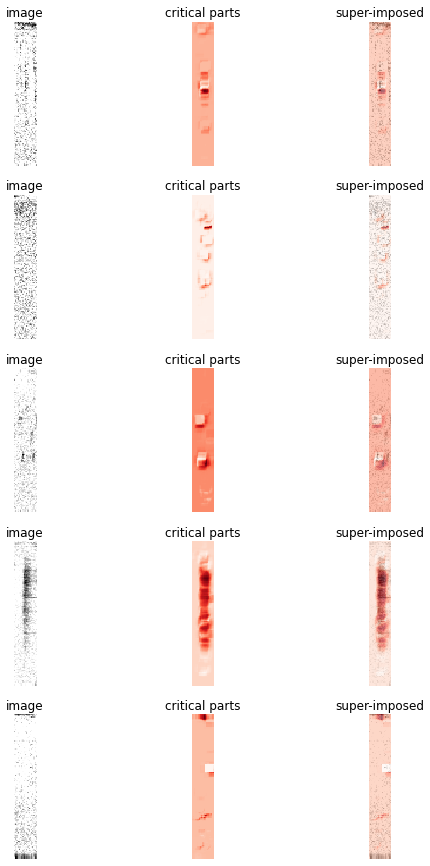

In [33]:
plot_occlusion(net0, train['X'][10:15], train['y'][10:15])

## Plotting the distribution of predictions for each class

In [34]:
plt.figure(figsize=(13, 3))
plt.boxplot([pred_y[test['y'] == 0], pred_y[test['y'] == 1]], 0, 'b+', 0)
plt.xlim(0, 1)
plt.plot([0.5, 0.5], [0, 3], 'k:')
plt.xlabel('CNN prediction')
plt.gca().set_yticklabels(['No biotic', 'Biotic'])
plt.title('CNN prediction for each class')

NameError: name 'pred_y' is not defined